In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install -q efficientnet

In [ ]:
#tf.test.gpu_device_name()

In [ ]:
!ls '/content/drive/My Drive/Object_detection'

OD_1.ipynb  sf-dl-nucleus-detection.zip


In [ ]:
!unzip '/content/drive/My Drive/Object_detection/sf-dl-nucleus-detection.zip'

Archive:  /content/drive/My Drive/Object_detection/sf-dl-nucleus-detection.zip
  inflating: sample_submission.csv   
  inflating: test.zip                
  inflating: train.zip               
  inflating: train_labels.csv        


In [ ]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import os
import glob
import random

import skimage.io                           #Used for imshow function
import skimage.transform                    #Used for resize function
from skimage.morphology import label        #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import efficientnet.tfkeras as efn

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

# Custom IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

IMG_WIDTH       = 256
IMG_HEIGHT      = 256
IMG_CHANNELS    = 3

In [ ]:
train_labels = pd.read_csv('train_labels.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [ ]:
# распаковываем данные
for name_data in ['test', 'train']:
    tmp_zip = zipfile.ZipFile(name_data+'.zip')
    tmp_zip.extractall(name_data)
    tmp_zip.close()

In [ ]:
!ls

drive		  sample_data		 test	   train	     train.zip
requirements.txt  sample_submission.csv  test.zip  train_labels.csv


In [ ]:
# для подгрузки данных будем использовать удобную либу skimage
def get_X_data(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path)]
    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], 
                                                output_shape=output_shape, 
                                                mode='constant', 
                                                preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data

def get_Y_data(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path)]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data

In [ ]:
%%time
# Get training data
X_train = get_X_data('train', output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(X_train.shape, X_train.dtype)

(670, 256, 256, 3) uint8
CPU times: user 19.3 s, sys: 15.4 s, total: 34.7 s
Wall time: 18.3 s


In [ ]:
%%time
# Get training data labels
Y_train = get_Y_data('train', output_shape=(IMG_HEIGHT,IMG_WIDTH))
print(Y_train.shape, Y_train.dtype)

(670, 256, 256, 1) bool
CPU times: user 1min 2s, sys: 32.2 s, total: 1min 35s
Wall time: 1min


In [ ]:
%%time
X_test = get_X_data('test', output_shape=(IMG_HEIGHT,IMG_WIDTH))

CPU times: user 1.94 s, sys: 1.44 s, total: 3.39 s
Wall time: 1.76 s


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=13)

data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

X_datagen = ImageDataGenerator(**data_gen_args)
Y_datagen = ImageDataGenerator(**data_gen_args)
test_datagen = ImageDataGenerator()
X_datagen_val = ImageDataGenerator()
Y_datagen_val = ImageDataGenerator()

X_datagen.fit(x_train, augment=True, seed=13)
Y_datagen.fit(y_train, augment=True, seed=13)
test_datagen.fit(X_test, augment=True, seed=13)
X_datagen_val.fit(x_test, augment=True, seed=13)
Y_datagen_val.fit(y_test, augment=True, seed=13)

X_train_augmented = X_datagen.flow(x_train,  batch_size=15, shuffle=True, seed=13)
Y_train_augmented = Y_datagen.flow(y_train,  batch_size=15, shuffle=True, seed=13)
test_augmented = test_datagen.flow(X_test, shuffle=False, seed=13)
X_train_augmented_val = X_datagen_val.flow(x_test,  batch_size=15, shuffle=True, seed=13)
Y_train_augmented_val = Y_datagen_val.flow(y_test,  batch_size=15, shuffle=True, seed=13)

train_generator = zip(X_train_augmented, Y_train_augmented)
val_generator = zip(X_train_augmented_val, Y_train_augmented_val)

In [ ]:
base_model = efn.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

In [ ]:
base_model.trainable = True

In [ ]:
x10 = base_model.get_layer('stem_activation').output  # (128, 256, 4)
x20 = base_model.get_layer('block2d_add').output # (64, 128, 32)
x30 = base_model.get_layer('block3d_add').output  # (32, 64, 56)
x40 = base_model.get_layer('block5f_add').output  # (16, 32, 160)
x50 = base_model.get_layer('block7b_add').output  # (8, 16, 448)

In [ ]:
######################### pizdec
tf.keras.backend.clear_session()
nb_filter = [32,64,128,256,512]
# Build U-Net++ model
#inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
qq = base_model.layers[0].output
s = Lambda(lambda x: x / 255) (qq)


c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.5) (c1)
c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = Dropout(0.5) (c1)
p1 = MaxPooling2D((2, 2), strides=(2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.5) (c2)
c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = Dropout(0.5) (c2)
p2 = MaxPooling2D((2, 2), strides=(2, 2)) (c2)

up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_2)
c3 = Dropout(0.5) (c3)
c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = Dropout(0.5) (c3)

conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
conv3_1 = Dropout(0.5) (conv3_1)
conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_1)
conv3_1 = Dropout(0.5) (conv3_1)
pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
conv2_2 = concatenate([up2_2, c2, x10], name='merge22', axis=3) #x10
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)
conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_2)
conv2_2 = Dropout(0.5) (conv2_2)

up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)
conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_3)
conv1_3 = Dropout(0.5) (conv1_3)

conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool3)
conv4_1 = Dropout(0.5) (conv4_1)
conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_1)
conv4_1 = Dropout(0.5) (conv4_1)
pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
conv3_2 = concatenate([up3_2, conv3_1, x20], name='merge32', axis=3) #x20
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)
conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_2)
conv3_2 = Dropout(0.5) (conv3_2)

up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
conv2_3 = concatenate([up2_3, c2, conv2_2, x10], name='merge23', axis=3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)
conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_3)
conv2_3 = Dropout(0.5) (conv2_3)

up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)
conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_4)
conv1_4 = Dropout(0.5) (conv1_4)

conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (pool4)
conv5_1 = Dropout(0.5) (conv5_1)
conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv5_1)
conv5_1 = Dropout(0.5) (conv5_1)

up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
conv4_2 = concatenate([up4_2, conv4_1, x30], name='merge42', axis=3) #x30
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)
conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv4_2)
conv4_2 = Dropout(0.5) (conv4_2)

up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
conv3_3 = concatenate([up3_3, conv3_1, conv3_2, x20], name='merge33', axis=3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)
conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv3_3)
conv3_3 = Dropout(0.5) (conv3_3)

up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3, x10], name='merge24', axis=3)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)
conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv2_4)
conv2_4 = Dropout(0.5) (conv2_4)

up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)
conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (conv1_5)
conv1_5 = Dropout(0.5) (conv1_5)

nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', kernel_initializer = 'he_normal',  name='output_4', padding='same')(conv1_5)

model = Model([base_model.input], [nestnet_output_4])
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=bce_dice_loss)#, metrics=[mean_iou])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , 
                             monitor = 'val_loss', 
                             verbose = 1, 
                             save_best_only=True,
                             mode = 'min',
                             save_weights_only=True,
                             save_freq='epoch'
                            )
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.00005)

callbacks_list = [checkpoint, reduce_lr]

# Fit model
history = model.fit(train_generator,  
                    validation_data=val_generator,
                    steps_per_epoch=len(X_train)/(6),
                    validation_steps=10,
                    callbacks=callbacks_list,
                    epochs=45, 
                    verbose=1,)

Epoch 1/45
112/111 [==============================] - ETA: 0s - loss: -0.5660
Epoch 00001: val_loss improved from inf to -0.60062, saving model to best_model.hdf5
112/111 [==============================] - 74s 664ms/step - loss: -0.5660 - val_loss: -0.6006 - lr: 0.0010
Epoch 2/45
112/111 [==============================] - ETA: 0s - loss: -0.7805
Epoch 00002: val_loss improved from -0.60062 to -0.73886, saving model to best_model.hdf5
112/111 [==============================] - 73s 652ms/step - loss: -0.7805 - val_loss: -0.7389 - lr: 0.0010
Epoch 3/45
112/111 [==============================] - ETA: 0s - loss: -0.8142
Epoch 00003: val_loss improved from -0.73886 to -0.80759, saving model to best_model.hdf5
112/111 [==============================] - 73s 649ms/step - loss: -0.8142 - val_loss: -0.8076 - lr: 0.0010
Epoch 4/45
112/111 [==============================] - ETA: 0s - loss: -0.8191
Epoch 00004: val_loss did not improve from -0.80759
112/111 [==============================] - 73s 652

In [ ]:
model.load_weights('best_model.hdf5')

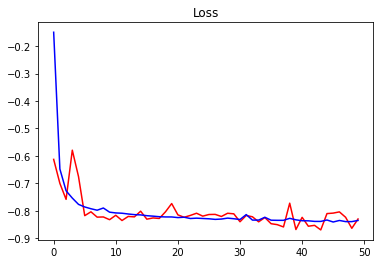

In [ ]:
def plot_loss_history(history):
    # validation losses
    val_loss = history.history['val_loss']
    loss = history.history['loss']

    plt.title('Loss')
    plt.plot(val_loss, 'r', loss, 'b')
    plt.show()
    
plot_loss_history(history)

In [ ]:
Y_predict = model.predict(X_train, verbose=1)
Y_predict.shape

21/21 [==============================] - 6s 301ms/step


(670, 256, 256, 1)

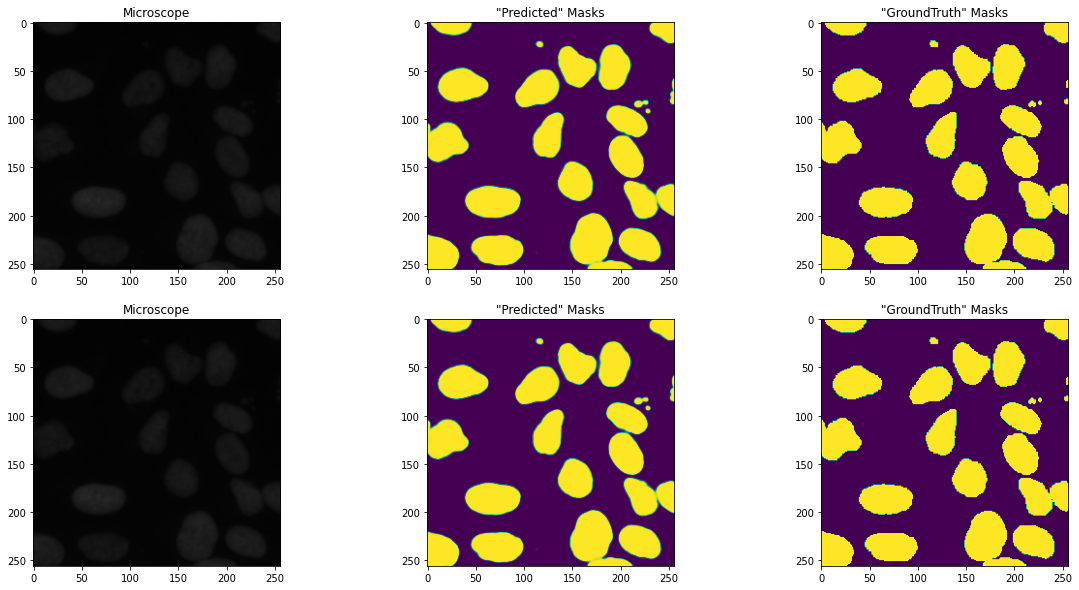

In [ ]:
train_ids = next(os.walk('train'))
test_ids = next(os.walk('test'))
# Check predict data
f, axarr = plt.subplots(2,3)
f.set_size_inches(20,10)
ix = random.randint(0, len(train_ids[1]))
axarr[0,0].imshow(X_train[ix])
axarr[0,0].set_title('Microscope')
axarr[0,1].imshow(np.squeeze(Y_predict[ix]))
axarr[0,1].set_title('"Predicted" Masks')
axarr[0,2].imshow(np.squeeze(Y_train[ix]))
axarr[0,2].set_title('"GroundTruth" Masks')

axarr[1,0].imshow(X_train[ix])
axarr[1,0].set_title('Microscope')
axarr[1,1].imshow(np.squeeze(Y_predict[ix]))
axarr[1,1].set_title('"Predicted" Masks')
axarr[1,2].imshow(np.squeeze(Y_train[ix]))
axarr[1,2].set_title('"GroundTruth" Masks')

plt.show()

In [ ]:
# Get test data
X_test = get_X_data('test', output_shape=(IMG_HEIGHT,IMG_WIDTH))

# Use model to predict test labels
Y_hat = model.predict(X_test, verbose=1)
Y_hat.shape

3/3 [==============================] - 0s 112ms/step


(65, 256, 256, 1)

(256, 256, 3)


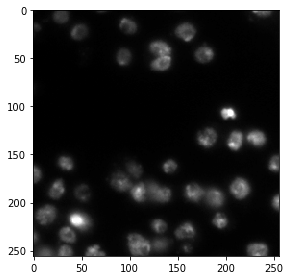

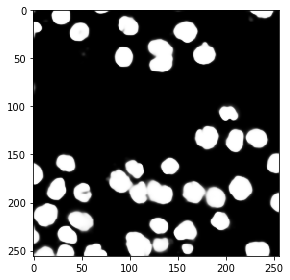

In [ ]:
idx = random.randint(0, len(test_ids[1]))
print(X_test[idx].shape)
skimage.io.imshow(X_test[idx])
plt.show()
skimage.io.imshow(Y_hat[idx][:,:,0])
plt.show()

In [ ]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.6):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [ ]:
# Upsample Y_hat back to the original X_test size (height and width)
Y_hat_upsampled = []
for i, test_id in enumerate(os.listdir('test')):  #loop through test_ids in the test_path
    img = skimage.io.imread('{0}/{1}/images/{1}.png'.format('test', test_id))  #read original test image directly from path
    img_upscaled = skimage.transform.resize(Y_hat[i], (img.shape[0], img.shape[1]), mode='constant', preserve_range=True)  #upscale Y_hat image according to original test image
    Y_hat_upsampled.append(img_upscaled)   #append upscaled image to Y_hat_upsampled
len(Y_hat_upsampled)

65

In [ ]:
# Apply Run-Length Encoding on our Y_hat_upscaled
new_test_ids = []
rles = []
for n, id_ in enumerate(os.listdir('test')):
    rle = list(prob_to_rles(Y_hat_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))
len(new_test_ids)  #note that for each test_image, we can have multiple entries of encoded pixels

2387

In [ ]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

In [ ]:
len(sub)

2366

In [ ]:
0.1*0.5

0.05

In [ ]:
sub.to_csv('/content/drive/My Drive/Object_detection/submission_35.csv', index=False)

In [ ]:
sub

,ImageId,EncodedPixels
0,52b267e20519174e3ce1e1994b5d677804b16bc670aa5f...,156 6 417 5 678 3
1,52b267e20519174e3ce1e1994b5d677804b16bc670aa5f...,205 17 465 17 725 17 985 17 1245 17 1505 16 17...
2,52b267e20519174e3ce1e1994b5d677804b16bc670aa5f...,231 18 491 17 751 17 1013 14
3,52b267e20519174e3ce1e1994b5d677804b16bc670aa5f...,253 8 513 8 773 8 1033 8 1294 7 1555 6 1815 6 ...
4,52b267e20519174e3ce1e1994b5d677804b16bc670aa5f...,2155 5 2170 8 2414 8 2427 13 2673 9 2686 15 29...
...,...,...
2493,5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3ed...,151485 16 151997 16 152506 22 153017 24 153529...
2494,5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3ed...,168061 10 168573 10 169081 16 169593 16 170104...
2495,5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3ed...,171773 10 172285 10 172796 12 173303 24 173815...
2496,5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3ed...,198747 34 199259 34 199767 42 200279 42 200790...


# New Section

In [ ]:
"""tf.keras.backend.clear_session()
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
#c5 = BatchNormalization() (c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
#optimizer = Adam(lr=LR,)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='binary_crossentropy')"""